# Siamese One-Shot-Learning Network, AT&T Faces

In [1]:
import os
import codecs
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import random
import datetime
import time

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.utils import save_image

## Set Configs

In [3]:
TRAIN_DIR = './datasets/faces/training/'
TEST_DIR = './datasets/faces/testing/'
BATCH_SIZE = 64
N_EPOCHS = 100 # try to train by 100 epochs to get better results
LR = 0.0005
N_GPU = 1

In [4]:
# decide which device we want to run on
device = torch.device('cuda:0' if (torch.cuda.is_available() and N_GPU > 0) else 'cpu')

## Set Helpers

In [5]:
def show_img(img, text=None, figsize=(20,20), should_save=False):
    
    img = img.numpy()
    plt.figure(figsize=figsize)
    plt.axis('off')
    if text:
        plt.text(75, 8, text, style='italic', fontweight='bold',
            bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10 })
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

## Configure Custom Data Loader

In [6]:
class SiameseNetworkDataset(torch.utils.data.Dataset):
    
    def __init__(self, datasets, transform=None, should_invert=True):
        self.datasets = datasets
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self, index):
        
        imageA_tupple = random.choice(self.datasets.imgs)
        should_get_same_class = random.randint(0,1) # make sure approx 50% of images are in the same class
        if should_get_same_class:
            while True:
                # keep looping until the same class image is found
                imageB_tupple = random.choice(self.datasets.imgs)
                if imageA_tupple[1] == imageB_tupple[1]:
                    break
        else:
            while True:
                # keep looping until the different class image is found
                imageB_tupple = random.choice(self.datasets.imgs)
                if imageA_tupple[1] != imageB_tupple[1]:
                    break
                    
        imageA = Image.open(imageA_tupple[0])
        imageB = Image.open(imageB_tupple[0])
        
        # the L means that it is just stores the Luminance. It is very compact, but only stores a greyscale, not colour
        imageA = imageA.convert('L')
        imageB = imageB.convert('L')
        
        if self.should_invert:
            imageA = ImageOps.invert(imageA)
            imageB = ImageOps.invert(imageB)
            
        if self.transform is not None:
            imageA = self.transform(imageA)
            imageB = self.transform(imageB)
        
        # return image A, image B and its similariy score (label)
        return imageA, imageB, torch.from_numpy(np.array([int(imageA_tupple[1] != imageB_tupple[1])], dtype=np.float32))
    
    def __len__(self):
        return len(self.datasets.imgs)

In [7]:
transform = transforms.Compose([
                            transforms.Resize((100,100)),
                            transforms.ToTensor()
])

In [8]:
datasets = torchvision.datasets.ImageFolder(root=TRAIN_DIR)
siamese_datasets = SiameseNetworkDataset(datasets=datasets, transform=transform, should_invert=False)

In [9]:
data_loader = DataLoader(siamese_datasets, shuffle=True, num_workers=8, batch_size=BATCH_SIZE)

In [10]:
train_loader = DataLoader(siamese_datasets, shuffle=True, num_workers=8, batch_size=BATCH_SIZE)

## Visualize Data

In [22]:
example_batch = next(iter(data_loader))
print('Batch consists {} data including image A, image B and its similarity score (label).'.format(len(example_batch)))

Batch consists 3 data including image A, image B and its similarity score (label).


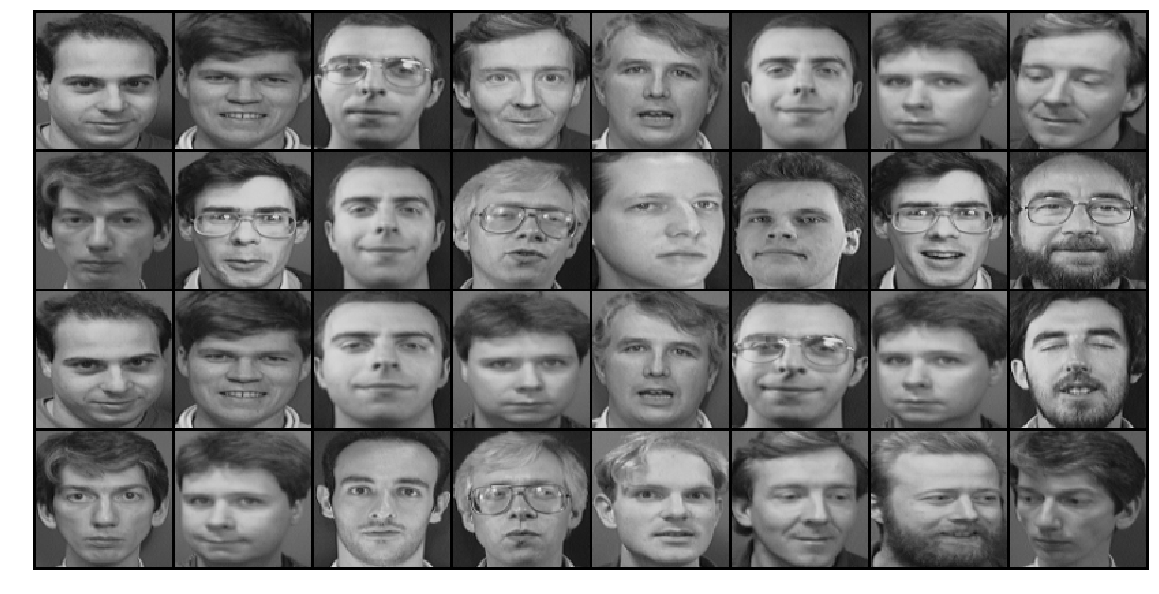

In [12]:
concatenated = torch.cat((example_batch[0][:16], example_batch[1][:16]),0)
show_img(torchvision.utils.make_grid(concatenated))

## Build [Siamese Network](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf) Architecture

In [13]:
class SiamaseNet(nn.Module):
    
    def __init__(self):
        super(SiamaseNet, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True), # it will modify the input directly and slightly decrease the memory usage
            nn.BatchNorm2d(4),
        
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
        
            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),)
        
        self.fc_layer = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),
            
            nn.Linear(500, 500),
            nn.ReLU(inplace=True),
        
            nn.Linear(500, 5))
        
    def forward_once(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size()[0], -1)
        x = self.fc_layer(x)
        
        return x
    
    def forward(self, imageA, imageB):
        resultA = self.forward_once(imageA)
        resultB = self.forward_once(imageB)
        
        return resultA, resultB

#### Initialize Siamese Network

In [14]:
siamese = SiamaseNet().to(device)

## Loss [Function](http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf)

In [15]:
class ContrastiveLoss(torch.nn.Module):
    
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin # used to determine the limit to which examples from different pairs are penalized
        
    def forward(self, resultA, resultB, label):
        euclidean_distance = F.pairwise_distance(resultA, resultB, keepdim=True) # L2 Norm
        contrastive_loss = torch.mean((1-label) * torch.pow(euclidean_distance, 2) + 
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        
        # this loss function will encourages the models to output feature vectors that are more similar, whereas if the classes differ
        # and will encourages the models to output feature vectors that are less similar
        return contrastive_loss

In [16]:
contrastive_loss = ContrastiveLoss()

## Set Optimizer

In [17]:
optimizer = optim.Adam(siamese.parameters(), lr=LR)

## Train The Network

In [18]:
counter = []
train_loss_history = []
n_iteration = 0
for epoch in range(N_EPOCHS):
    for batch_idx, data in enumerate(train_loader):
        imageA, imageB, label = data
        imageA, imageB, label = imageA.to(device), imageB.to(device), label.to(device)
        
        optimizer.zero_grad()
        resultA, resultB = siamese(imageA, imageB)
        loss = contrastive_loss(resultA, resultB, label)

        loss.backward()
        optimizer.step()
        
        if batch_idx % 10 == 0:
            print('Train Epoch: {} Loss: {:.6f}'.format(epoch+1, loss.item()))
            n_iteration += 10
            counter.append(n_iteration)
            train_loss_history.append(loss.item())
            
            if not os.path.exists('./weights/faces/'): os.makedirs('./weights/faces/')
            torch.save(siamese, './weights/faces/siamese_{:03}.pt'.format(epoch+1))

Train Epoch: 1 Loss: 1.332219


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type SiamaseNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Train Epoch: 2 Loss: 3.758626
Train Epoch: 3 Loss: 2.299492
Train Epoch: 4 Loss: 2.297795
Train Epoch: 5 Loss: 0.907741
Train Epoch: 6 Loss: 0.790878
Train Epoch: 7 Loss: 0.682935
Train Epoch: 8 Loss: 0.533849
Train Epoch: 9 Loss: 0.441962
Train Epoch: 10 Loss: 0.403577
Train Epoch: 11 Loss: 0.264576
Train Epoch: 12 Loss: 0.437061
Train Epoch: 13 Loss: 0.188510
Train Epoch: 14 Loss: 0.237835
Train Epoch: 15 Loss: 0.141411
Train Epoch: 16 Loss: 0.155192
Train Epoch: 17 Loss: 0.193256
Train Epoch: 18 Loss: 0.129292
Train Epoch: 19 Loss: 0.069225
Train Epoch: 20 Loss: 0.114823
Train Epoch: 21 Loss: 0.093593
Train Epoch: 22 Loss: 0.048647
Train Epoch: 23 Loss: 0.052663
Train Epoch: 24 Loss: 0.079552
Train Epoch: 25 Loss: 0.054659
Train Epoch: 26 Loss: 0.045253
Train Epoch: 27 Loss: 0.042058
Train Epoch: 28 Loss: 0.071449
Train Epoch: 29 Loss: 0.050278
Train Epoch: 30 Loss: 0.030569
Train Epoch: 31 Loss: 0.036776
Train Epoch: 32 Loss: 0.043837
Train Epoch: 33 Loss: 0.040095
Train Epoch: 34 

## Evaluate The Network

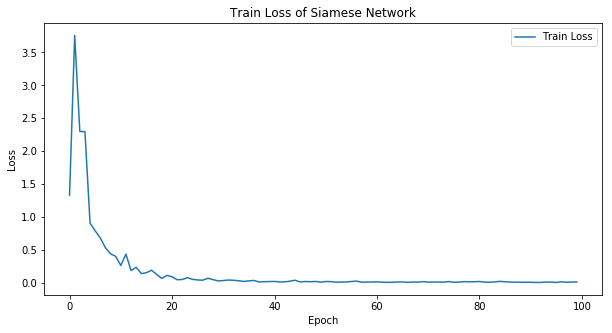

In [19]:
plt.figure(figsize=(10,5))
plt.title("Train Loss of Siamese Network")
plt.plot(train_loss_history, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

if not os.path.exists('./images/faces/'): os.makedirs('./images/faces/')
plt.savefig('./images/faces/final_train_loss.png')
plt.show()

In [20]:
datasets = torchvision.datasets.ImageFolder(root=TEST_DIR)
siamese_datasets = SiameseNetworkDataset(datasets=datasets,
                                         transform=transform,
                                         should_invert=False)

test_loader = DataLoader(siamese_datasets, num_workers=6, batch_size=1, shuffle=True)

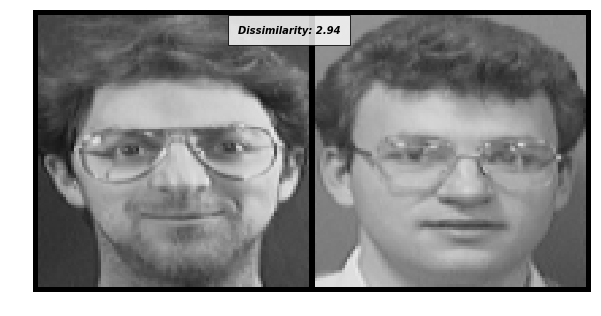

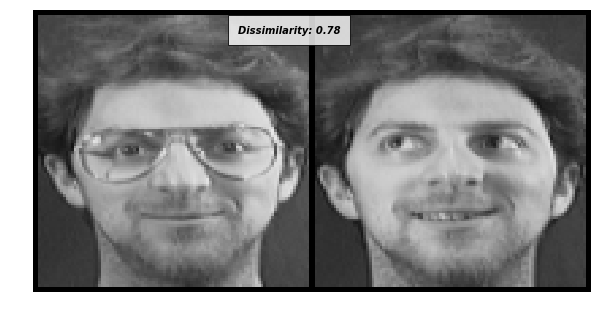

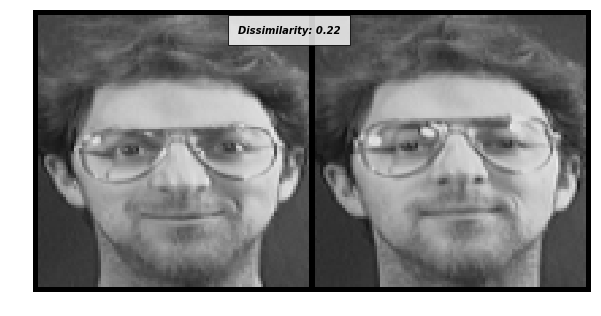

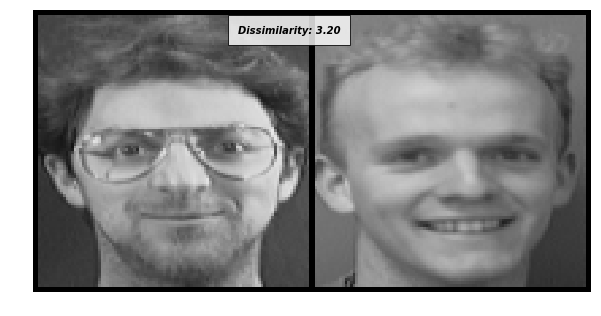

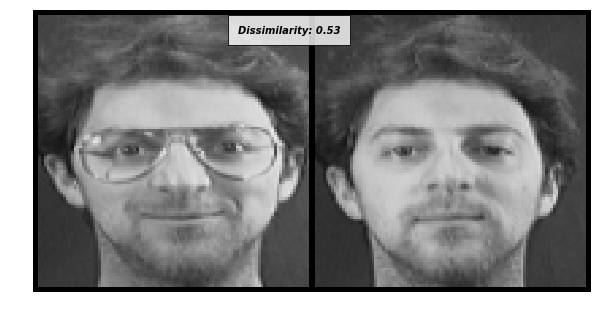

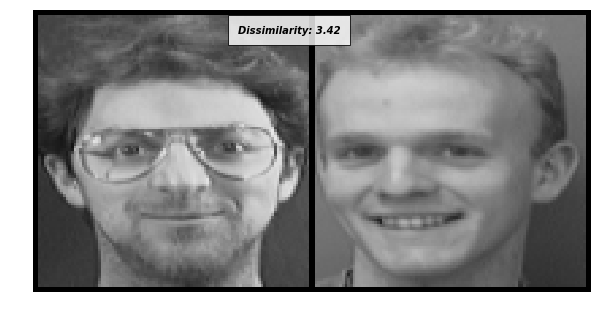

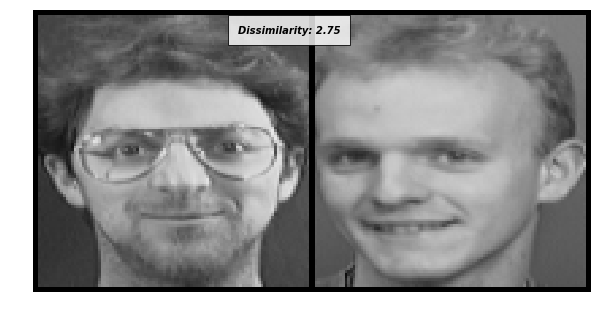

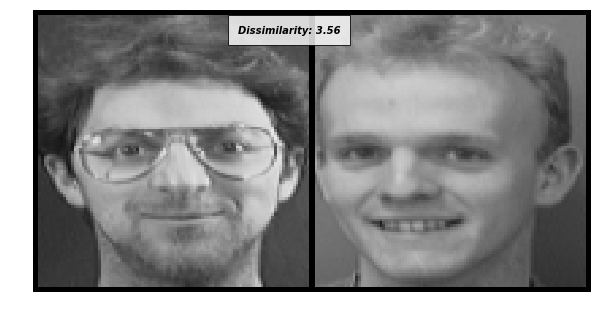

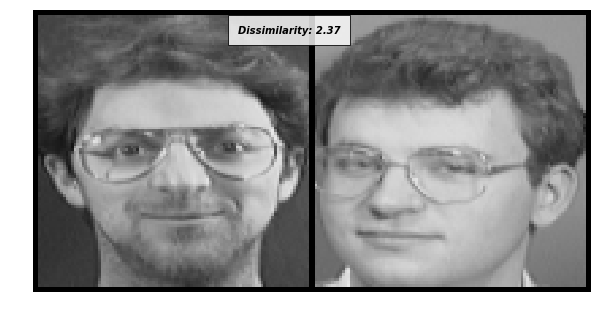

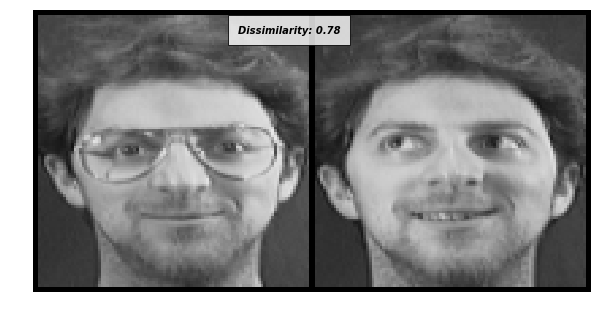

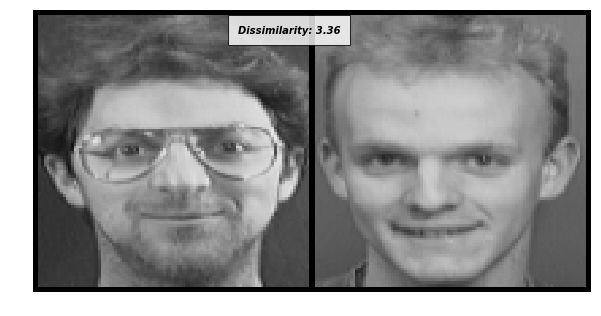

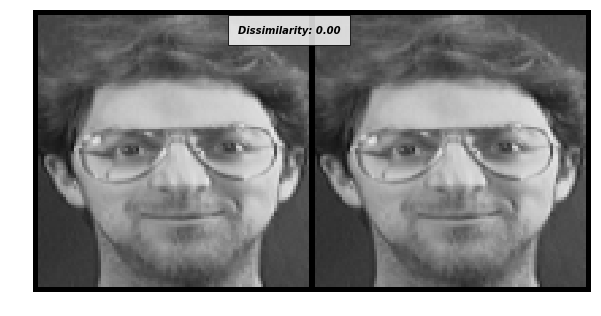

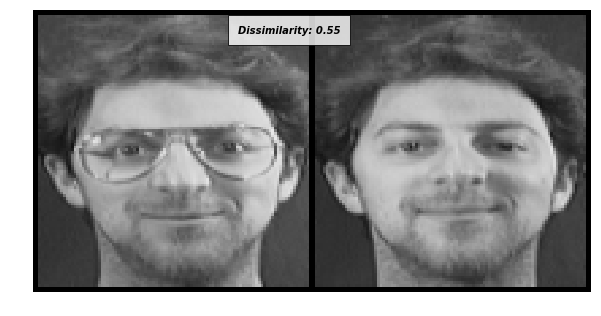

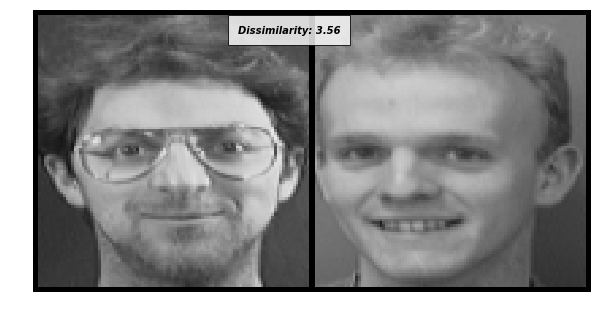

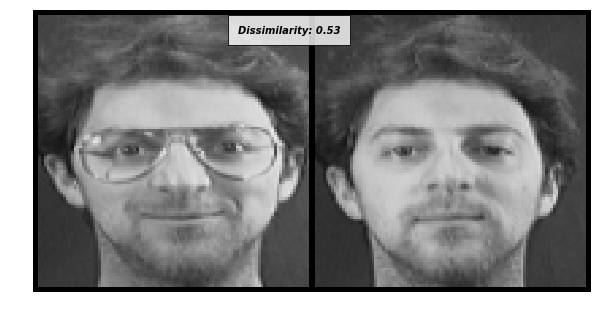

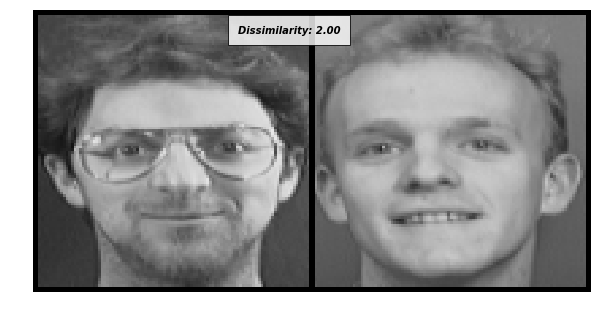

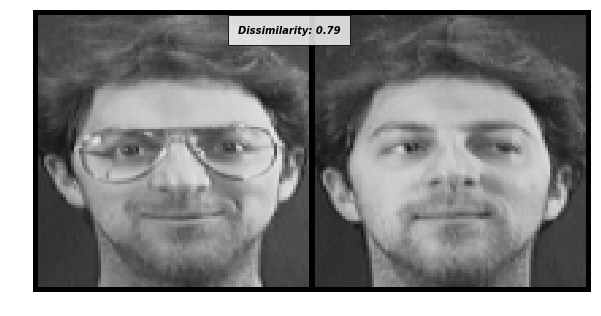

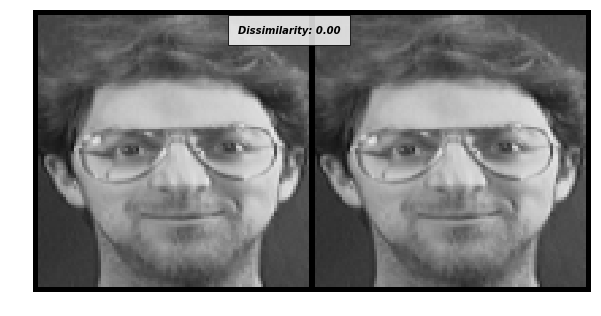

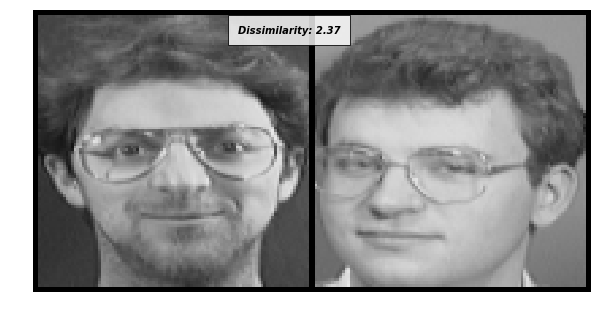

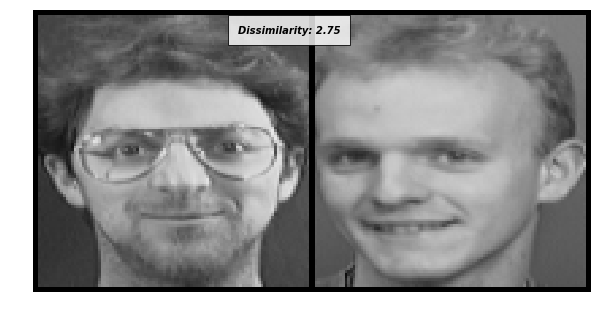

In [25]:
data_iter = iter(test_loader)
imageA, _, _ = next(data_iter)
for i in range(20):
    _, imageB, label = next(data_iter)
    concatenated = torch.cat((imageA, imageB),0)
    
    resultA, resultB = siamese(Variable(imageA).to(device), Variable(imageB).to(device))
    euclidean_distance = F.pairwise_distance(resultA, resultB)
    show_img(torchvision.utils.make_grid(concatenated), 'Dissimilarity: {:.2f}'.format(euclidean_distance.item()), figsize=(10,10))

---